In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def parse_sharp(line):
    def find_tuple(line):
        idx1 = line.find("(")
        idx2 = line[idx1+1:].find(")") + idx1+1
        w_strs = line[idx1+1:idx2].split(",")[:-1]
        w = [0] * len(w_strs)
        for i in range(len(w_strs)):
            w[i] = float(w_strs[i])
        return w, idx1, idx2
    
    line  = line[1:]
    w, _, idx2 = find_tuple(line)
    g, _, _ = find_tuple(line[idx2+1:])
    return w, g
    

def parse_log(log_file, begin_line=0, to_float_k=["train_acc", "valid_acc", "loss"]):
    obj = {'weight':[], 'grad':[]}
    with open(log_file) as f:
        lines = f.readlines()[begin_line:]
        for line in lines:
            line = line.strip()
            if line[0:1] == "#": 
                w, g = parse_sharp(line)
                if len(w) > 0 and len(g) > 0:
                    obj['weight'].append(w)
                    obj['grad'].append(g)
                continue
            vs = []
            for d in line.split(","):
                d = d.strip()
                i = d.rfind(' ')
                k = d[:i].strip()
                v = d[i+1:].strip()
                obj[k] = obj.get(k, [])
                obj[k].append(v)
        if len(lines) > 0:
            for k in to_float_k:
                if obj.has_key(k):
                    obj[k] = to_float(obj[k])
    return obj

def to_float(str_list):
    fa = []
    for s in str_list:
        fa.append(float(s))
    return fa

def plot(data, key, x_range=None):
    x_range = (0, len(data[key])) if x_range is None else x_range
    if x_range[1] == -1:  x_range = (x_range[0], len(data[key]))
    plt.plot(range(*x_range), data[key][x_range[0]:x_range[1]], label=key)
    plt.legend(loc="upper left")
    plt.xlabel("epoch")
    plt.ylabel(key)
    
dataset = {}
data_init = {"train_acc": []}

def update(log_file, x_range=None):
    dataset[log_file] = dataset.get(log_file, {"train_acc": []})
    data = dataset[log_file]
    
    def get_begin_line(log_file, data):
        epochs = len(data["train_acc"])
        if epochs == 0: return 0, 0
        l = 0
        with open(log_file) as f:
            for i, line in enumerate(f.readlines()):
                line = line.strip()
                if line[0:1] != "#":
                    l += 1
                if l >= epochs:
                    return i+1, l
    
    # update date
    begin_line, _  = get_begin_line(log_file, data)
    _data = parse_log(log_file, begin_line=begin_line)
    for k in _data:
        data[k] = data.get(k, [])
        data[k].extend(_data[k])
    if not data.has_key("valid_acc") or not data.has_key("train_acc") or not data.has_key("loss"):
        return
    
    # plot
    plt.figure(figsize=(12, 4))   # (w, h)
    plt.subplot(1, 2, 1)
    plot(data, 'train_acc', x_range)
    plot(data, 'valid_acc', x_range)
    #plt.show()
    plt.subplot(1, 2, 2)
    plot(data, 'loss', x_range)
    plt.show()
    print "lr", sorted(to_float(set(data['lr'])), reverse=True)
    
    # weight and grad
    data = dataset[log_file]["weight"]
    if len(data) == 0: return
    data = np.array(data)
    grad = dataset[log_file]["grad"]
    if len(grad) == 0: return
    grad = np.array(grad)
    print np.mean(data, axis=0), np.var(data, axis=0)
    print np.mean(grad, axis=0), np.var(grad, axis=0)

### Exp2:res164_v2 + DA2: 0.9527

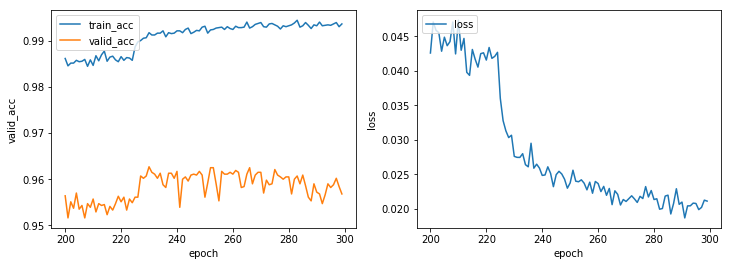

lr [0.1, 0.01, 0.001]
[ 0.15251918  0.04320721  0.19337752] [ 0.00037762  0.00015233  0.00072116]
[ 0.53227317  0.0643048   0.1752995 ] [ 0.06582715  0.00060626  0.02188111]


In [6]:
update("log/log_res164__1.log", x_range=(200, -1))

### Exp3: res164_v2 + focal loss + DA3: 0.9540

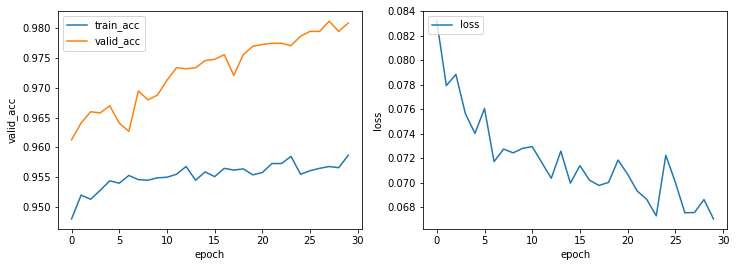

lr [0.001]
[ 0.11422295  0.02652034  0.14024605] [  2.66254941e-07   8.28515572e-09   5.69715937e-08]
[ 0.45338633  0.05211995  0.08677074] [ 0.02547261  0.0002148   0.00078552]


In [8]:
update("log/log_res164__2_e255_focal_clip_all_data.log")  # epoch 225-255

### Exp4: res164_v2 + focal loss + DA3 + only train_data: 0.9506

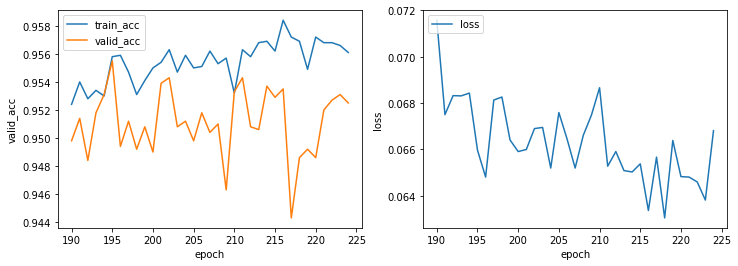

lr [0.1, 0.01]
[ 0.13160615  0.03597419  0.17727516] [ 0.00019777  0.00019981  0.00048741]
[ 0.48636278  0.05257401  0.20957084] [ 0.03066464  0.00020483  0.01894174]


In [9]:
update("log/log_res164__2_e0-225_focal_clip.log", x_range=(190, -1))